In [2]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/net/mulan/home/huiwann/spatial/SVC/')
import tifffile
from model.train import *
from model.utils import *
import torch 
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import wilcoxon 

In [3]:
data_path = '/net/mulan/home/huiwann/spatial/SVC/' 
dataset = 'data/merfish_U2OS' 
device = 'cuda:1'

In [4]:
gene_names = np.loadtxt(f'{data_path}{dataset}/gene_names.txt', dtype=str)
gene_names = gene_names.tolist()
cell_names = np.loadtxt(f'{data_path}{dataset}/cell_names.txt', dtype=str)

test_merfish_U2OS = np.load(f"{data_path}{dataset}/test_merfish_U2OS.npz")  # 或 "cuda"
test_image = test_merfish_U2OS["data_ori"]
test_cell_morphology = test_merfish_U2OS["cell_morphology"]
test_nuclear_morphology = test_merfish_U2OS["nuclear_morphology"]
test_data_location = test_merfish_U2OS["location"]
test_cell_names = test_merfish_U2OS["cell_names"]
test_dataset = SVC_Dataset(
    data_ori=test_image,
    location=test_data_location,
    cell_morphology_vec=test_cell_morphology,
    nuclear_morphology_vec=test_nuclear_morphology,
)
print("number of testing cells:", len(test_dataset),', number of genes:', test_image.shape[1])
train_count_sum = np.load(f'{data_path}output/merfish_U2OS/train_count_sum.npy')
read_dir =f'{data_path}{dataset}/gene2vec_weight_merfish_U2OS.npy'

number of testing cells: 122 , number of genes: 119


In [ ]:
background_pixel = torch.Tensor([[0,0],[0,1],[0,10],[0,11],[1,0],[1,11],[10,0],[10,11],[11,0],[11,1],[11,10],[11,11]]).to(device).to(torch.long)
foreground = torch.ones((12, 12), dtype=torch.bool, device=device)  
foreground[background_pixel[:, 0], background_pixel[:, 1]] = False
foreground_flat= foreground.flatten().cpu()  
foreground_expanded = foreground.reshape(1, 1, 12, 12)

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=2025)

groups = []
for train_index, test_index in kf.split(gene_names):
    groups.append(np.array(gene_names)[test_index])

for i, group in enumerate(groups):
    print(f"Group {i+1}: {group}")

Group 1: ['AGAP1' 'CCDC113' 'IGF2R' 'IL17RA' 'MCF2L' 'NRIP1' 'PLXNA2' 'SAMD12'
 'SMARCA5' 'SPTBN1' 'XDH' 'YIPF4']
Group 2: ['AHDC1' 'AKAP11' 'AMOTL1' 'CDYL2' 'CNR2' 'CRTAP' 'FAF2' 'KLHL9' 'PRKCA'
 'PRPF8' 'RAD51D' 'SLC7A11']
Group 3: ['AFF4' 'ALPK2' 'BSN' 'FASN' 'FBN2' 'GPR107' 'GTF3C4' 'HERC2' 'PHIP'
 'SLC9A2' 'TTPAL' 'UBR2']
Group 4: ['AFAP1' 'ARL10' 'DIP2B' 'FBN1' 'MED14' 'PRDM2' 'SLC35B4' 'SMIM5' 'TNRC6A'
 'TSTD2' 'USP9X' 'USP34']
Group 5: ['AGPS' 'CREBBP' 'EGFR' 'ITPR2' 'LRP1' 'MYH10' 'NHSL2' 'PIK3CA' 'PRKDC'
 'SLC5A3' 'THSD4' 'UMPS']
Group 6: ['ANKH' 'BUB3' 'CBX5' 'CEMIP' 'CHST3' 'KIF13B' 'MAN1A2' 'NKTR' 'SOD2'
 'STARD9' 'TSPAN3' 'USP8']
Group 7: ['DNAJC13' 'KPNA4' 'LMTK2' 'LUZP1' 'POLQ' 'RNF152' 'SLC38A1' 'SSH1' 'TLN1'
 'USP24' 'VPS13D' 'ZNF592']
Group 8: ['BRCA2' 'CBL' 'COL5A1' 'DYNC1H1' 'FAM184B' 'FZD4' 'FZD5' 'HEATR5B'
 'PROSER1' 'PTPN14' 'RNF169' 'THBS1']
Group 9: ['AGO3' 'ANKRD52' 'C14orf132' 'CEP250' 'CKAP5' 'FYCO1' 'PAPPA' 'RBM20'
 'SKP1' 'SULT1C2' 'TPR' 'UBR5']
Group 10:

In [7]:
ckpt_dir = f"{data_path}checkpoints/"
ckpt = torch.load(ckpt_dir +'SVC_merfish_U2OS.pth', map_location=device)

new_ckpt = {k.replace('module.', ''): v for k, v in ckpt['model_state_dict'].items()}

gene2vec_weight = torch.from_numpy(np.load(read_dir)).float() ##n_gene * 200
print("shape of gene2vec_weight", gene2vec_weight.shape)
# # define ViT model
model = SVC(
    gene2vec_weight = gene2vec_weight,
    use_cell_identity = False,
).to(device)

model_dict = model.state_dict()
for key in model_dict:
    model_dict[key] = new_ckpt[key]
model.load_state_dict(model_dict)


shape of gene2vec_weight torch.Size([119, 200])


<All keys matched successfully>

In [8]:
val_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False, num_workers = 4)
model.eval()
predictions_concat_mu = torch.zeros(test_image.shape).to(device) 
predictions_concat_r = torch.zeros(test_image.shape).to(device)
embeddings_concat = torch.zeros(len(test_cell_names), len(gene_names), 384).to(device) 
for selected_gene in groups:

    gene_to_impute = [gene_names.index(i) for i in selected_gene if i in gene_names]# #[0,2,4,6,8,10]# #range(15,21)#
    gene_not_to_impute = [gene for gene in range(len(gene_names)) if gene not in gene_to_impute]
    gene_to_impute_name = [gene_names[i] for i in gene_to_impute]

    predictions_mu= []     
    predictions_r = []
    embeddings = []

    with torch.no_grad():
        for i, (inputs_ori, cell_morphology, nuclear_morphology, location) in enumerate(val_loader, 0):
            
            inputs_ori = inputs_ori.to(device)           
            location = location.to(device).float()
            cell_morphology_vec = cell_morphology.to(device).float()
            nuclear_morphology_vec = nuclear_morphology.to(device).float()
            inputs_ori_mask = inputs_ori.clone()
            inputs_ori_mask[:,gene_to_impute] = 0

            cell_median_train = np.median((train_count_sum[:,gene_not_to_impute]).sum(axis=1))
            size_factor = inputs_ori_mask.sum((1,2,3))/cell_median_train
            size_factor = size_factor.unsqueeze(1).unsqueeze(2).unsqueeze(3)
            inputs = inputs_ori / size_factor  # (n_cell, n_gene, 12, 12)


            mask = torch.zeros(inputs.shape[0], inputs.shape[1]).to(device).bool()
            
            mask[:,gene_to_impute] = True
            inputs_mask = inputs.clone()
            inputs_mask[:,gene_to_impute] = 0
            embedding, predicts_mu, predicts_r = model(inputs_mask, mask, location, cell_morphology_vec, nuclear_morphology_vec)             
            predicts_mu = predicts_mu * size_factor  # batch*gene*h*w


            predictions_mu.append(predicts_mu)
            predictions_r.append(predicts_r)
            embeddings.append(embedding)
        

            
    predictions_mu = torch.cat(predictions_mu, dim=0)
    predictions_r = torch.cat(predictions_r, dim=0)
    embeddings = torch.cat(embeddings, dim=0)
  
    predictions_mu[:,:,background_pixel[:,0],background_pixel[:,1]] = 0
    predictions_r[:,:,background_pixel[:,0],background_pixel[:,1]] = 0

    predictions_concat_mu[:,gene_to_impute] = predictions_mu[:,gene_to_impute]     
    predictions_concat_r[:,gene_to_impute] = predictions_r[:,gene_to_impute]
    embeddings_concat[:,gene_to_impute] = embeddings[:,gene_to_impute]
    

np.savez_compressed(f'{data_path}output/merfish_U2OS/prediction_all_genes_mu.npz', prediction=predictions_concat_mu.cpu().numpy())
np.savez_compressed(f'{data_path}output/merfish_U2OS/prediction_all_genes_r.npz', prediction=predictions_concat_r.cpu().numpy())

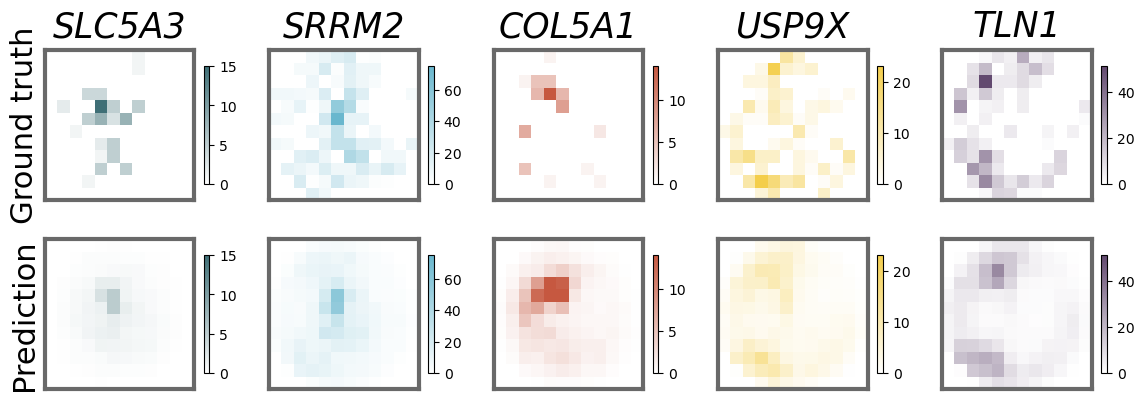

In [ ]:
custom_cmap_1 = create_white_to_color_cmap('#3f6f76')
custom_cmap_2 = create_white_to_color_cmap('#69b7ce')
custom_cmap_3 = create_white_to_color_cmap('#c65840')
custom_cmap_4 = create_white_to_color_cmap('#f4ce4b')
custom_cmap_5 = create_white_to_color_cmap('#62496f')
custom_cmap  = [custom_cmap_1,custom_cmap_2,custom_cmap_3,custom_cmap_4,custom_cmap_5]
cell = '11-64'#
cell_idx = list(test_cell_names).index(cell)

fig, ax = plt.subplots(2, 5, figsize=(14, 4.5), gridspec_kw={ "hspace": 0.2})
i = 0
gene1='SLC5A3'
gene2='SRRM2'
gene3='COL5A1'
gene4='USP9X'
gene5='TLN1'
gene_id = [gene1,gene2,gene3,gene4,gene5]

for gene in gene_id:

    cell_gene = predictions_concat_mu[cell_idx].cpu().numpy()
    cell_gene_real = test_image[cell_idx]
    vmax = cell_gene_real[gene_names.index(gene_id[i]),:,:,].max()
    cell_gene_sum = cell_gene.sum(axis = 0)

    ax0 = ax[0,i].imshow(cell_gene_real[gene_names.index(gene_id[i]),:,:,], cmap=custom_cmap[i],vmin=0,vmax=vmax)#,vmin=-0.2,vmax=15)
    if  i == 0:
        ax[i,0].set_ylabel("Ground truth",fontsize=22)
    ax[0,i].set_title(f"{gene_names[gene_names.index(gene_id[i])]}",fontsize=25,pad=10,fontstyle='italic')
    cbar = plt.colorbar(ax0,shrink=0.75)
    
    ax[0,i].invert_yaxis()
    for spine in ax[0,i].spines.values():
        spine.set_linewidth(3)
        spine.set_color('dimgrey')
    ax1 = ax[1,i].imshow(cell_gene[gene_names.index(gene_id[i]),:,:,], cmap=custom_cmap[i],vmin=0,vmax=vmax)
    cbar = plt.colorbar(ax1,shrink=0.75)
    if  i == 0:
        ax[1,i].set_ylabel(f"Prediction",fontsize=22)
    ax[1,i].invert_yaxis()
    for spine in ax[1,i].spines.values():
        spine.set_linewidth(3)
        spine.set_color('dimgrey')
    ax[0,i].set_xticks([]) 
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])

    i+=1
 
plt.tight_layout()
plt.show()
plt.close()


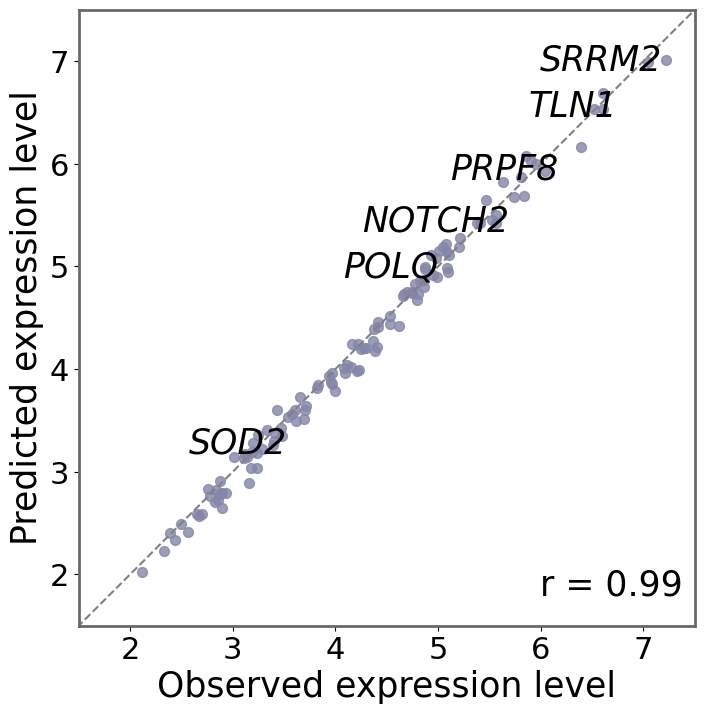

In [10]:
real_exp_mean = test_image.sum((-1,-2)).mean(0)
impute_exp_mean = predictions_concat_mu.sum((-1,-2)).mean(0).cpu().numpy()
impute_real_concat = np.concatenate((real_exp_mean.reshape(-1,1), impute_exp_mean.reshape(-1,1)), axis=1)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#518463","#254750"])
ax.scatter(np.log1p(impute_real_concat[:,0]), np.log1p(impute_real_concat[:,1]),s=50,color='#8386A8',alpha=0.8)

ax.text(0.98, 0.05, f'r = {np.corrcoef(impute_real_concat[:,0], impute_real_concat[:,1])[0, 1]:.2f}', transform=ax.transAxes, ha='right',fontsize=25)
for gene in gene_names:
    if gene in ['NOTCH2','TLN1','SRRM2','POLQ','SOD2','PRPF8']:
        ax.annotate(gene, (np.log1p(impute_real_concat[gene_names.index(gene),0]), np.log1p(impute_real_concat[gene_names.index(gene),1])), textcoords="offset points", xytext=(10,-6), ha='right', fontsize=25,fontstyle='italic')

ax.set_aspect('equal')
ax.plot([0, 8], [0, 8], '--', color='gray')
ax.set_xlim(1.5, 7.5)
ax.set_ylim(1.5, 7.5)
ax.set_xticks([2,3,4,5,6,7])
ax.set_xticklabels([2,3,4,5,6,7],fontsize=22)
ax.set_yticks([2,3,4,5,6,7])
ax.set_yticklabels([2,3,4,5,6,7],fontsize=22)
ax.set_xlabel('Observed expression level', fontsize=25)
ax.set_ylabel('Predicted expression level', fontsize=25)
for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('dimgrey')

In [ ]:
spliced_unspliced = np.load(f"{data_path}{dataset}/splice_unsplice.npz")
spliced = spliced_unspliced["splice"]
unspliced = spliced_unspliced["unsplice"]
test_indices = [i for i, name in enumerate(cell_names) if name in test_cell_names]
test_spliced = spliced[test_indices]
test_unspliced = unspliced[test_indices]


In [16]:
prediction_gene_ratio = np.zeros((len(test_dataset),len(gene_names)))
truth_gene_ratio = np.zeros((len(test_dataset),len(gene_names)))
I = 0
for cell in range(len(test_dataset)):
    cell_gene_pred = predictions_concat_mu[cell].cpu().numpy()
    cell_gene_real = test_image[cell]
    J = 0
    for gene in range(len(gene_names)):
        heatmap_pred = cell_gene_pred[gene,:,:,]  
        heatmap_real = cell_gene_real[gene,:,:,]
        total_sum_pred = np.sum(heatmap_pred)
        total_sum_real = np.sum(heatmap_real)
        if total_sum_pred != 0:
            ratio_pred = 0
            for i in range(heatmap_pred.shape[0]):
                for j in range(heatmap_pred.shape[1]):
                    ratio_pred += np.sqrt((i+0.5-6)**2 + (j+0.5-6)**2)/6 * heatmap_pred[i, j]

            ratio_pred /= total_sum_pred
            ratio_pred = np.min([ratio_pred,1])
            prediction_gene_ratio[I,J] = ratio_pred

        if total_sum_real != 0:
            ratio_real = 0
            for i in range(heatmap_real.shape[0]):
                for j in range(heatmap_real.shape[1]):
                    ratio_real += np.sqrt((i+0.5-6)**2 + (j+0.5-6)**2)/6 * heatmap_real[i, j]
 
            ratio_real /= total_sum_real
            ratio_real = np.min([ratio_real,1])
            truth_gene_ratio[I,J] = ratio_real

        J += 1
    I += 1

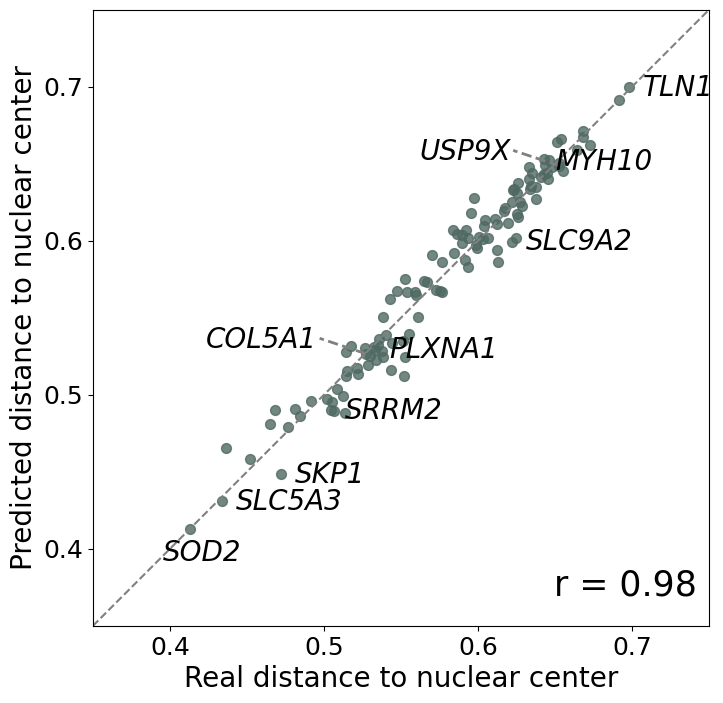

In [17]:
prediction_gene_ratio_mean = np.sum(prediction_gene_ratio,axis=0)
prediction_gene_ratio_mean = prediction_gene_ratio_mean/np.sum(prediction_gene_ratio!=0,axis=0)
truth_gene_ratio_mean =  np.sum(truth_gene_ratio,axis=0)
truth_gene_ratio_mean = truth_gene_ratio_mean/np.sum(truth_gene_ratio!=0,axis=0)
impute_real_concat = np.concatenate((np.array(truth_gene_ratio_mean).reshape(-1,1),np.array(prediction_gene_ratio_mean).reshape(-1,1)), axis=1)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(impute_real_concat[:,0], impute_real_concat[:,1],s=50,label=type,alpha=0.8,color='#4f6962')

ax.text(0.98, 0.05, f'r = {np.corrcoef(impute_real_concat[:,0], impute_real_concat[:,1])[0, 1]:.2f}', transform=ax.transAxes, ha='right',fontsize=25)
for gene in gene_names:
    if gene in ['SLC5A3','SRRM2',"SKP1","CDY12","TLN1","SLC9A2","PLXNA1"]:
        ax.annotate(gene, (impute_real_concat[gene_names.index(gene),0], impute_real_concat[gene_names.index(gene),1]), textcoords="offset points", xytext=(10,-6), ha='left', fontsize=20,fontstyle='italic')
    if gene in ['SOD2','MYH10']:        
            ax.annotate(gene, (impute_real_concat[gene_names.index(gene),0], impute_real_concat[gene_names.index(gene),1]), textcoords="offset points", xytext=(-20,-23), ha='left', fontsize=20,fontstyle='italic')
    if gene in ['COL5A1','USP9X']:
        xi,yi=impute_real_concat[gene_names.index(gene),0], impute_real_concat[gene_names.index(gene),1]
        ax.plot([xi,xi-0.03],[yi,yi+0.01],linestyle='--',color='gray',linewidth=2)
        ax.annotate(gene, (xi-0.03,yi+0.01), textcoords="offset points",  xytext=(-2,-7), ha='right', fontsize=20,fontstyle='italic')
ax.set_aspect('equal')
ax.plot([0, 0.8], [0, 0.8], '--', color='gray')
ax.set_xlim(0.35, 0.75)
ax.set_ylim(0.35, 0.75)
ax.set_xticks([0.4,0.5,0.6,0.7])
ax.set_xticklabels([0.4,0.5,0.6,0.7],fontsize=18)
ax.set_yticks([0.4,0.5,0.6,0.7])
ax.set_yticklabels([0.4,0.5,0.6,0.7],fontsize=18)
ax.set_xlabel('Real distance to nuclear center', fontsize=20)
ax.set_ylabel('Predicted distance to nuclear center', fontsize=20)
plt.show()

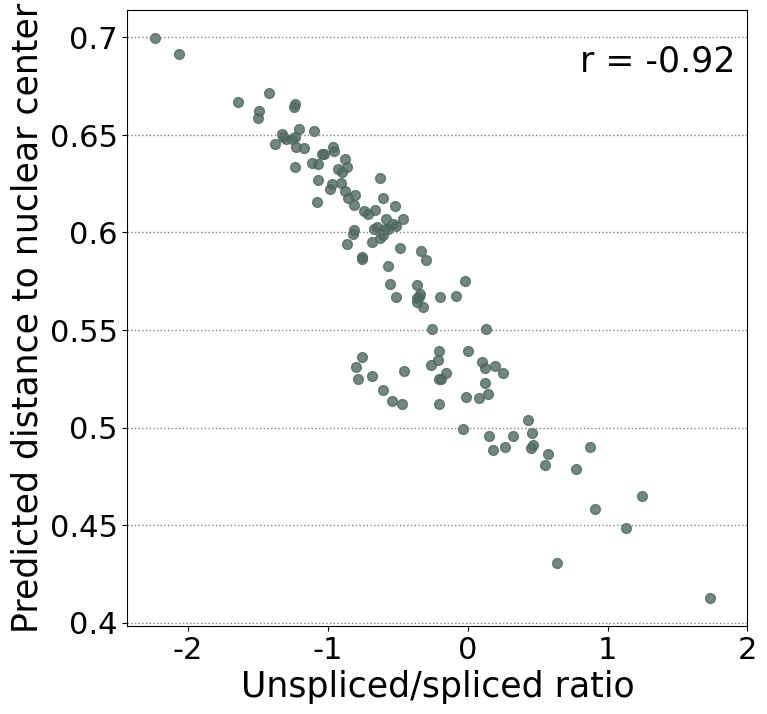

In [18]:
from scipy.stats import pearsonr 
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
US_ratio = np.log1p(test_unspliced)-(np.log1p(test_spliced))
ax.scatter(US_ratio.mean(0), prediction_gene_ratio_mean, s=50,label=type,alpha=0.8,color='#4f6962')

corr, pvalue = pearsonr(US_ratio.mean(0),prediction_gene_ratio_mean)
ax.text(0.98, 0.9, f'r = {corr.round(2)}', transform=ax.transAxes, ha='right',fontsize=25)

ax.set_xticks(np.arange(-2,2.5, 1))
ax.set_xticklabels([-2,-1,0,1,2],fontsize=22)
ax.set_yticks([0.4,0.45,0.5,0.55,0.6,0.65,0.7])
ax.set_yticklabels([0.4,0.45,0.5,0.55,0.6,0.65,0.7],fontsize=22)
ax.set_xlabel('Unspliced/spliced ratio', fontsize=25)
ax.set_ylabel('Predicted distance to nuclear center', fontsize=25)
### set grid
plt.grid(axis='y', color='gray', linestyle=':',linewidth=1)
plt.show()

In [19]:
predictions_exp_level = predictions_concat_mu.sum(dim=(2,3))
predictions_frac = predictions_concat_mu/predictions_exp_level.unsqueeze(-1).unsqueeze(-1)
predictions_frac_flat = predictions_frac.reshape(predictions_frac.shape[0], predictions_frac.shape[1], -1)
predicitons_entropy = -torch.sum(predictions_frac_flat * torch.log(predictions_frac_flat + 1e-10)/np.log(foreground_flat.sum()), dim=-1)
predicitons_entropy_avg = torch.mean(predicitons_entropy, dim=0).cpu().numpy()


In [20]:
low_entropy = np.array(gene_names)[predicitons_entropy_avg.argsort()[:10]]
high_entropy = np.array(gene_names)[predicitons_entropy_avg.argsort()[::-1][:10]]
print("Low entropy genes:",low_entropy)
print("High entropy genes:",high_entropy)

Low entropy genes: ['SOD2' 'FBN2' 'SLC5A3' 'COL5A1' 'LRP1' 'NOTCH2' 'IGF2R' 'SKP1' 'THBS1'
 'PLXNA1']
High entropy genes: ['CEMIP' 'FAM184B' 'BSN' 'SLC9A2' 'C14orf132' 'THSD4' 'SULT1C2' 'SAMD12'
 'CNR2' 'RBM20']


In [22]:
print("Low entropy genes:")
for i in low_entropy:
    print(i)
print("High entropy genes:")
for i in high_entropy:
    print(i)

Low entropy genes:
SOD2
FBN2
SLC5A3
COL5A1
LRP1
NOTCH2
IGF2R
SKP1
THBS1
PLXNA1
High entropy genes:
CEMIP
FAM184B
BSN
SLC9A2
C14orf132
THSD4
SULT1C2
SAMD12
CNR2
RBM20


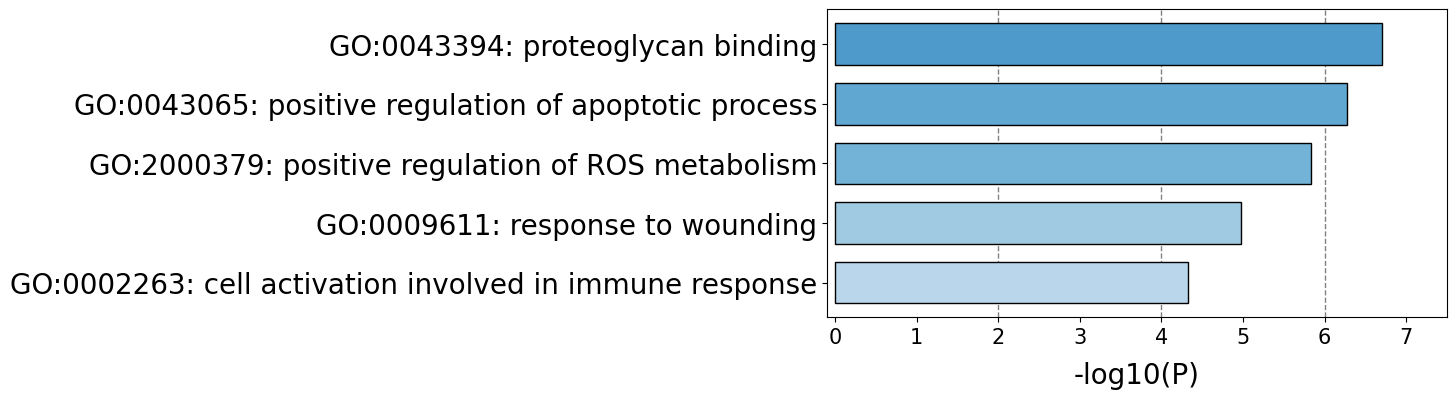

In [ ]:
df_low_entropy = pd.read_excel(f'{data_path}output/merfish_U2OS/GO_enrich_Merfish_U2OS_low_entropy_10_genes.xlsx', sheet_name=None, engine="openpyxl")   
df_low_entropy = df_low_entropy['Sheet1'] 
df_low_entropy.loc[
    df_low_entropy['Description'] == 'positive regulation of reactive oxygen species metabolic process',
    'Description'
] = 'positive regulation of ROS metabolism'
from matplotlib.colors import Normalize
fig,ax = plt.subplots(1,1,figsize=(8,4),)
norm = Normalize(2,10)
colors = plt.cm.Blues(norm(-df_low_entropy['Log10(P)']))
bars = ax.barh(
    y=df_low_entropy['GO']+": "+df_low_entropy['Description'],            
    width=-df_low_entropy['Log10(P)'], 
    edgecolor='black',       
    color=colors,            
    alpha=1,               
    height=0.7               
)

ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=15)
ax.set_axisbelow(True)
ax.axvline(x=2, color='gray', linestyle='--', linewidth=1,zorder=0) 
ax.axvline(x=4, color='gray', linestyle='--', linewidth=1,zorder=0)
ax.axvline(x=6, color='gray', linestyle='--', linewidth=1,zorder=0)
ax.set_xlabel('-log10(P)', fontsize=20, labelpad=10)
ax.invert_yaxis()
ax.set_xlim(-0.1,7.5)
plt.show()


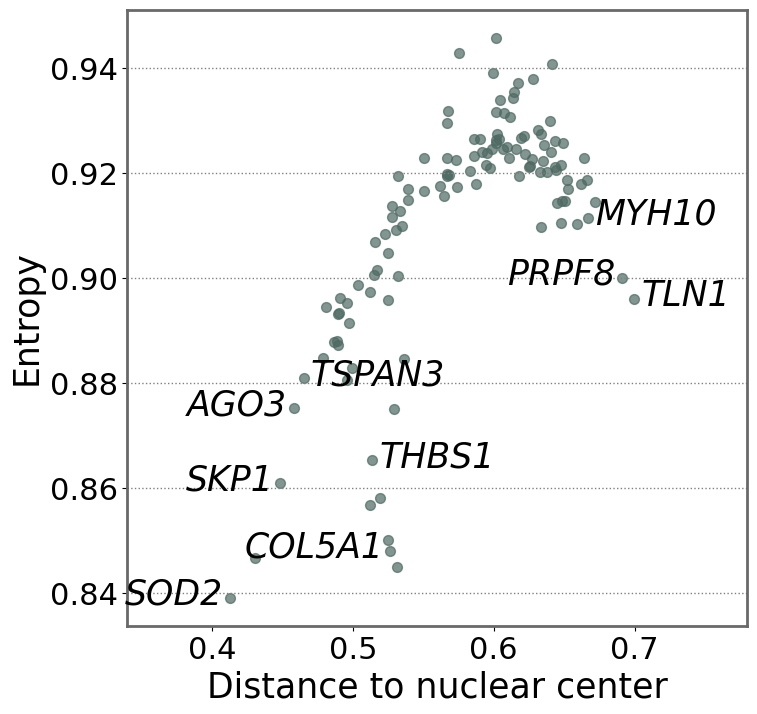

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(prediction_gene_ratio_mean, predicitons_entropy_avg, alpha=0.7,s=50,c='#4f6962')
annotate_kwargs = {
    'xycoords': 'data',
    'textcoords': 'offset points',
    'arrowprops': {
        'arrowstyle': '-',
        'color': 'gray',
        'lw': 2,
        'alpha': 0.7,
        'connectionstyle': 'arc3,rad=0'
    }
}

for gene in gene_names:     
    if gene in ['THBS1','MYH10','TSPAN3','TLN1']:
        ax.annotate(gene, (prediction_gene_ratio_mean[gene_names.index(gene)],predicitons_entropy_avg[gene_names.index(gene)]), textcoords="offset points", xytext=(5,-5), ha='left', fontsize=25,fontstyle='italic')
    if gene in ['COL5A1','SKP1','PRPF8','SOD2','AGO3']:
        ax.annotate(gene, (prediction_gene_ratio_mean[gene_names.index(gene)],predicitons_entropy_avg[gene_names.index(gene)]), textcoords="offset points", xytext=(-5,-5), ha='right', fontsize=25,fontstyle='italic')
plt.grid(axis='y', color='gray', linestyle=':',linewidth=1)
plt.xticks([0.4,0.5,0.6,0.7],fontsize=22)
plt.xlabel('Distance to nuclear center',fontsize=25)
plt.yticks(fontsize=22) 
plt.ylabel('Entropy',fontsize=25)
for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('dimgrey')
plt.xlim(0.34, 0.78)
plt.show()

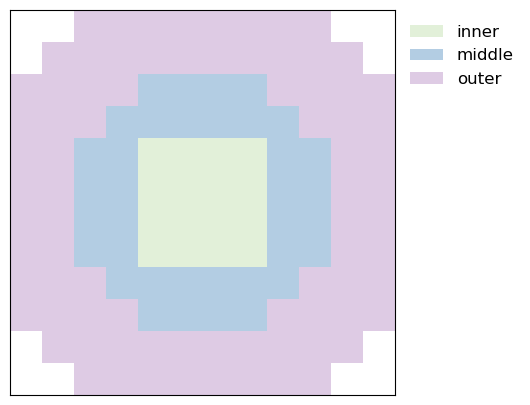

In [24]:
from matplotlib.patches import Patch
image = np.ones((12, 12, 3))

color1 = np.array([226, 240, 217]) / 255  # region_1 
color2 = np.array([179, 205, 227]) / 255  # region_2 
color3 = np.array([222, 203, 228]) / 255  # region_3 
region_1 = np.zeros([12,12])
region_1[4:8,4:8] = 1
region_1 = np.maximum(region_1,region_1.T)

region_2 = np.zeros([12,12])
region_2[3:9,3:9] =  1
region_2[2,4:8] =  1
region_2[9,4:8] =  1
region_2 = np.maximum(region_2,region_2.T)
region_2[region_1==1] = 0

region_3 = np.ones([12,12])
region_3[1,5:7] =  1
region_3[10,5:7] =  1
region_3[2,4:8] =  1
region_3[9,4:8] =  1
region_3[3,2:10] =  1
region_3[8,2:10] =  1
region_3[background_pixel.cpu().numpy()[:,0],background_pixel.cpu().numpy()[:,1]] = 0
region_3 = np.maximum(region_3,region_3.T)
region_3[region_2==1] = 0
region_3[region_1==1] = 0

image[region_1 == 1] = color1
image[region_2 == 1] = color2
image[region_3 == 1] = color3

# 显示图像
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.xlim(-0.5, 11.5)
plt.ylim(11.5, -0.5)
legend_elements = [     
    Patch(facecolor=color1, edgecolor='none', label='inner'),     
    Patch(facecolor=color2, edgecolor='none', label='middle'),     
    Patch(facecolor=color3, edgecolor='none', label='outer') 
    ] 
plt.legend(handles=legend_elements, frameon=False, loc='upper left', fontsize=12, bbox_to_anchor=(1, 1))
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
image_length = predictions_concat_mu.shape[2]
### for each cell and region, calculate the ratio of transcripts in each gene
pred_subregion_ratio = np.zeros((predictions_concat_mu.shape[0],predictions_concat_mu.shape[1],3))
truth_subregion_ratio = np.zeros((test_image.shape[0],test_image.shape[1],3))
for i in tqdm(range(len(predictions_concat_mu))):
    pred_i = predictions_concat_mu[i].cpu().detach().numpy()##119*12*12
    truth_i = test_image[i]

    pred_i_1, pred_i_2, pred_i_3 = pred_i[:,np.where(region_1==1)[0],np.where(region_1==1)[1]],pred_i[:,np.where(region_2==1)[0],np.where(region_2==1)[1]],pred_i[:,np.where(region_3==1)[0],np.where(region_3==1)[1]] 
    pred_i_1, pred_i_2, pred_i_3 = pred_i_1.sum(axis=1),pred_i_2.sum(axis=1),pred_i_3.sum(axis=1)
    pred_i_sum = pred_i_1 + pred_i_2 + pred_i_3 
    pred_i_1_ratio,pred_i_2_ratio,pred_i_3_ratio = pred_i_1/pred_i_sum, pred_i_2/pred_i_sum, pred_i_3/pred_i_sum
    pred_subregion_ratio[i] = np.stack([pred_i_1_ratio, pred_i_2_ratio, pred_i_3_ratio],axis=1)
    
    truth_i_1, truth_i_2, truth_i_3= truth_i[:,np.where(region_1==1)[0],np.where(region_1==1)[1]],truth_i[:,np.where(region_2==1)[0],np.where(region_2==1)[1]],truth_i[:,np.where(region_3==1)[0],np.where(region_3==1)[1]] 
    truth_i_1, truth_i_2, truth_i_3 = truth_i_1.sum(axis=1),truth_i_2.sum(axis=1),truth_i_3.sum(axis=1)
    truth_i_sum = truth_i_1 + truth_i_2 + truth_i_3 
    truth_i_1_ratio,truth_i_2_ratio,truth_i_3_ratio = truth_i_1/truth_i_sum, truth_i_2/truth_i_sum, truth_i_3/truth_i_sum
    truth_subregion_ratio[i] = np.stack([truth_i_1_ratio, truth_i_2_ratio, truth_i_3_ratio],axis=1)


pred_subregion_ratio_avg = np.nanmean(pred_subregion_ratio,axis=0) 
truth_subregion_ratio_avg = np.nanmean(truth_subregion_ratio,axis=0)

100%|██████████| 122/122 [00:00<00:00, 7146.12it/s]


In [35]:
### Human protein atlas (U2OS)
coding_protein_consistent_genes_0_HPA_U2OS = ['SKP1','TMOD2','SRRM2','POLQ']
coding_protein_consistent_genes_1_HPA_U2OS = ['COL5A1','THBS1','IGF2R','FBN1','PLXNA1','GPR107','SLC7A11']#,'LMTK2'
coding_protein_consistent_genes_2_HPA_U2OS = []

### Human protein atlas (other cell lines)
coding_protein_consistent_genes_0_HPA_other = ['TSPAN3','AGO3']
coding_protein_consistent_genes_1_HPA_other = ['LRP1','NOTCH2']#
coding_protein_consistent_genes_2_HPA_other = ['TLN1','RAB3B','FASN']

coding_protein_consistent_HPA_U2OS = [coding_protein_consistent_genes_0_HPA_U2OS,coding_protein_consistent_genes_1_HPA_U2OS,coding_protein_consistent_genes_2_HPA_U2OS]
coding_protein_consistent_HPA_other = [coding_protein_consistent_genes_0_HPA_other,coding_protein_consistent_genes_1_HPA_other,coding_protein_consistent_genes_2_HPA_other]


In [36]:
### calculate top 5 genes for each subregion
top_genes_subregion_pred = []
positions_real = []
positions_HPA_U2OS = []
positions_HPA_other = []


for i in range(3):
    pred_subregion_ratio_avg_i = pred_subregion_ratio_avg[:,i]
    truth_subregion_ratio_avg_i = truth_subregion_ratio_avg[:,i]
    top_pred_gene_i = np.array(gene_names)[np.argsort(pred_subregion_ratio_avg_i)[::-1][:10]]
    top_real_gene_i = np.array(gene_names)[np.argsort(truth_subregion_ratio_avg_i)[::-1][:10]]

    
    print("top predicted genes for subregion",i)
    print(top_pred_gene_i)

    print("top real genes for subregion",i)
    print(top_real_gene_i)

    overlap_HPA_U2OS = (np.intersect1d(top_pred_gene_i,coding_protein_consistent_HPA_U2OS[i]))
    print("overlap genes HPA (U2OS)",  len(overlap_HPA_U2OS), overlap_HPA_U2OS)

    overlap_HPA_other = (np.intersect1d(top_pred_gene_i,coding_protein_consistent_HPA_other[i]))     
    print("overlap genes HPA (other)",len(overlap_HPA_other), overlap_HPA_other)

    overlap_real = (np.intersect1d(top_pred_gene_i,top_real_gene_i))
    print("overlap genes real", len(overlap_real), overlap_real)

    add_points_HPA_U2OS = [(list(top_pred_gene_i).index(j)+10*i,i) for j in overlap_HPA_U2OS]
    add_points_HPA_other= [(list(top_pred_gene_i).index(j)+10*i,i) for j in overlap_HPA_other]
    add_points_real = [(list(top_pred_gene_i).index(j)+10*i,i) for j in overlap_real]
    print("\n")
    
    top_genes_subregion_pred.append(list(np.argsort(pred_subregion_ratio_avg_i)[::-1][:10]))
    positions_HPA_U2OS+=add_points_HPA_U2OS
    positions_HPA_other+=add_points_HPA_other
    positions_real+=add_points_real


heatmap_top = []
for i in range(3):
    heatmap_top.append(pred_subregion_ratio_avg[top_genes_subregion_pred[i]].tolist())
heatmap_top = np.concatenate(np.array(heatmap_top),axis=0)

top predicted genes for subregion 0
['SOD2' 'SLC5A3' 'AGO3' 'SKP1' 'YIPF4' 'SRRM2' 'TMOD2' 'RAD51D' 'TSPAN3'
 'POLQ']
top real genes for subregion 0
['SOD2' 'AGO3' 'TSPAN3' 'TMOD2' 'SLC5A3' 'UMPS' 'YIPF4' 'POLQ' 'RAD51D'
 'SRRM2']
overlap genes HPA (U2OS) 4 ['POLQ' 'SKP1' 'SRRM2' 'TMOD2']
overlap genes HPA (other) 2 ['AGO3' 'TSPAN3']
overlap genes real 9 ['AGO3' 'POLQ' 'RAD51D' 'SLC5A3' 'SOD2' 'SRRM2' 'TMOD2' 'TSPAN3' 'YIPF4']


top predicted genes for subregion 1
['FBN2' 'COL5A1' 'THBS1' 'LRP1' 'IGF2R' 'NOTCH2' 'FBN1' 'PLXNA1' 'GPR107'
 'SLC7A11']
top real genes for subregion 1
['FBN2' 'IGF2R' 'THBS1' 'NOTCH2' 'COL5A1' 'LRP1' 'FBN1' 'PLXNA1' 'GPR107'
 'LMTK2']
overlap genes HPA (U2OS) 7 ['COL5A1' 'FBN1' 'GPR107' 'IGF2R' 'PLXNA1' 'SLC7A11' 'THBS1']
overlap genes HPA (other) 2 ['LRP1' 'NOTCH2']
overlap genes real 9 ['COL5A1' 'FBN1' 'FBN2' 'GPR107' 'IGF2R' 'LRP1' 'NOTCH2' 'PLXNA1' 'THBS1']


top predicted genes for subregion 2
['TLN1' 'PRPF8' 'MYH10' 'RAB3B' 'DNAJC13' 'AGPS' 'FASN' 'ASCC

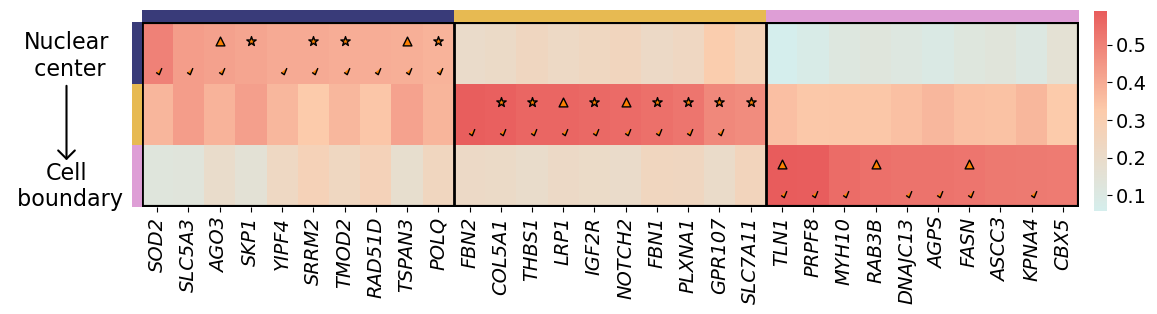

: 

In [ ]:
import seaborn as sns
from matplotlib.patches import FancyArrowPatch
from matplotlib.path import Path
colors= ["#D5EEED","#FCCBAB","#E85C5C"]
custom_cmap =LinearSegmentedColormap.from_list("custom_cmap", colors)
verts = [(-0.3, 0.0), (0.4, -0.5), (1.0, 1.0)]
codes = [Path.MOVETO, Path.LINETO, Path.LINETO]
check_path = Path(verts, codes)


fig = plt.figure(figsize=(13, 4))
top_pred_gene = [gene_names[j] for i in top_genes_subregion_pred for j in i]

row_categories = np.array([0,1,2]) 
gs = fig.add_gridspec(ncols=4,nrows=3, width_ratios=[0.01, 0.93,0.05,0.01],height_ratios=[0.36,0.04, 0.6],wspace=0,hspace=0)

ax_label = fig.add_subplot(gs[2,0])
ax_label.set_axis_off()

fig.text(
    x=0.075, y=0.55, s="Nuclear\n center", 
    ha='center', va='top',
    fontsize=16,
    transform=fig.transFigure 
)

fig.text(
    x=0.075, y=0.1, s="Cell\n boundary",
    ha='center', va='bottom',
    fontsize=16, 
    transform=fig.transFigure
)

arrow = FancyArrowPatch(
    posA=(0.075, 0.42), 
    posB=(0.075, 0.22),  
    arrowstyle='->,head_width=0.3,head_length=0.3',
    color='black',
    lw=1.5,
    transform=fig.transFigure,  
    mutation_scale=20,
    figure=fig  
)
fig.patches.append(arrow) 

# 左侧颜色条
ax_color = fig.add_subplot(gs[2,0])
sns.heatmap(
    row_categories.reshape(-1, 1), 
    cmap='tab20b',
    ax=ax_color,
    cbar=False,
    xticklabels=False,
    yticklabels=False
)

# 上侧颜色条
ax_top = fig.add_subplot(gs[1,1])
sns.heatmap(
    row_categories.reshape(-1, 1).T, 
    cmap='tab20b',
    ax=ax_top,
    cbar=False,
    xticklabels=False,
    yticklabels=False
)

# 主热力图
ax_heatmap = fig.add_subplot(gs[2,1])
ax_colorbar2 = fig.add_subplot(gs[2,3])

ax_colorbar2.set_position([0.865, 0.1, 0.01, 0.5])

heatmap = sns.heatmap(heatmap_top.T, cmap=custom_cmap, yticklabels=[], xticklabels=top_pred_gene, fmt=".2f",ax=ax_heatmap,cbar_ax=ax_colorbar2, cbar_kws={'shrink': 0.8,'aspect':1})

heatmap.set_xticklabels(heatmap.get_xticklabels(),fontsize=14, rotation=90,fontstyle='italic')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontweight='bold',fontsize=15)
cbar = heatmap.collections[0].colorbar

cbar.set_ticks([0.1,0.2,0.3,0.4,0.5])
cbar.ax.tick_params(labelsize=14)

cbar_ax = cbar.ax

text_obj = cbar_ax.get_yaxis().get_label()

text_obj.set_position((0.1, -1))
heatmap.axhline(y=0, color='black', linewidth=2)
heatmap.axhline(y=3, color='black', linewidth=3)
heatmap.axvline(x=0, color='black', linewidth=2)
heatmap.axvline(x=10, color='black', linewidth=2)
heatmap.axvline(x=20, color='black', linewidth=2)
heatmap.axvline(x=30, color='black', linewidth=3)

heatmap.axhline(y=0, color='black', linewidth=3)
heatmap.axhline(y=4, color='black', linewidth=3)
for pos in positions_HPA_U2OS:
        heatmap.scatter(pos[0]+0.5, pos[1]+0.3, marker='*', color='#fc8002', s=50, edgecolors='black',zorder=20)
for pos in positions_HPA_other:
        heatmap.scatter(pos[0]+0.5, pos[1]+0.3, marker='^', color='#fc8002', s=40, edgecolors='black')
for pos in positions_real:
        heatmap.scatter(pos[0]+0.5, pos[1]+0.8, marker=check_path, color='#fc8002', s=40, edgecolors='black')

plt.show()

